### Torch tuto on RNNs

Inspired from "Hands-On Machine Learning wuth Scikit-Learn, Keras and Tensorflow" (A Géron)
Translated to PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


In [4]:
# Set default tensor type to FloatTensor
torch.set_default_dtype(torch.float64)
  
# # default tensor type  
# if torch.cuda.is_available():
#     torch.set_default_dtype('torch.cuda.DoubleTensor')
# else:
#     torch.set_default_dtype('torch.DoubleTensor')

Data Generation for Time Series Forecasting

In [5]:
def generate_time_series(batch_size, n_steps):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.5 * np.sin((time - o1) * (f1 * 10 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o1) * (f1 * 20 + 20)) # second sine wave
    series += 0.1 * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [6]:
n_steps = 50
n_series = 10000
s = generate_time_series(n_series, n_steps+1)

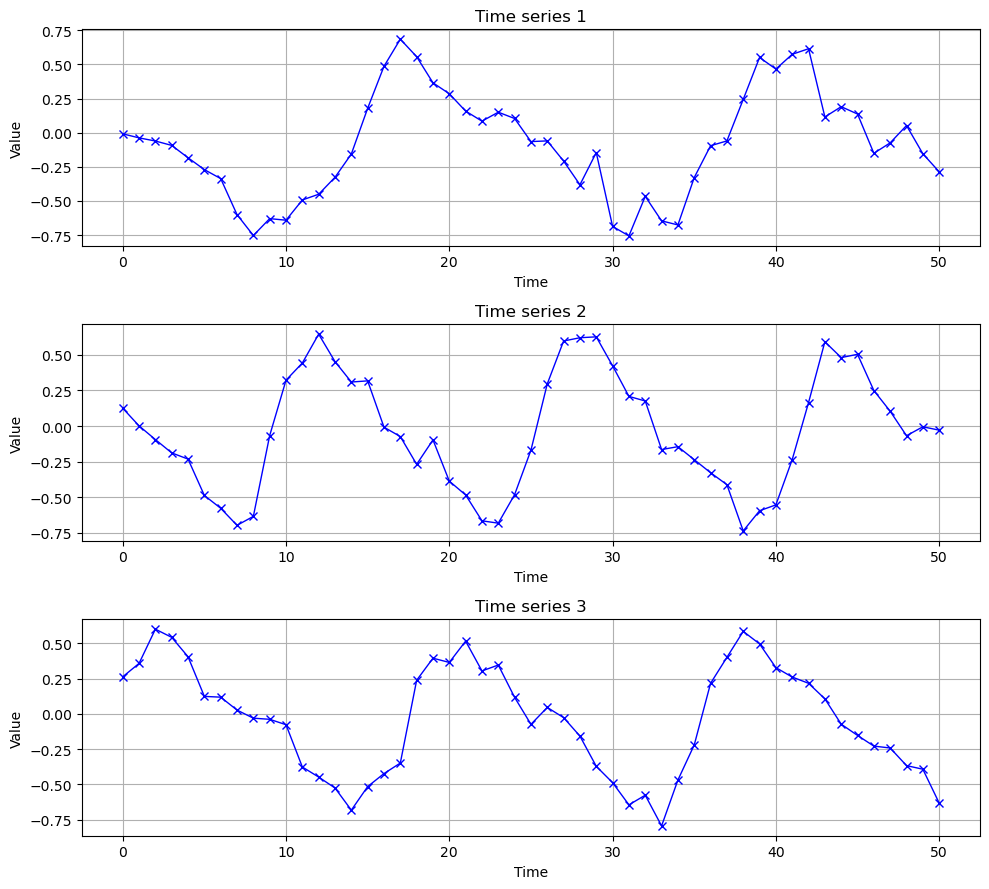

In [7]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [61]:
X_train, y_train = s[:7000,:n_steps], s[:7000,-1]
X_valid, y_valid = s[7000:9000,:n_steps], s[7000:9000,-1]
X_test, y_test = s[9000:,:n_steps], s[9000:,-1]

In [62]:
# form datasets, dataloaders, etc

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Baseline metrics

In [63]:
# Predicted value is the last value of the time series

y_pred = X_valid[:,-1]
print(f"{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

0.1609 RMSE


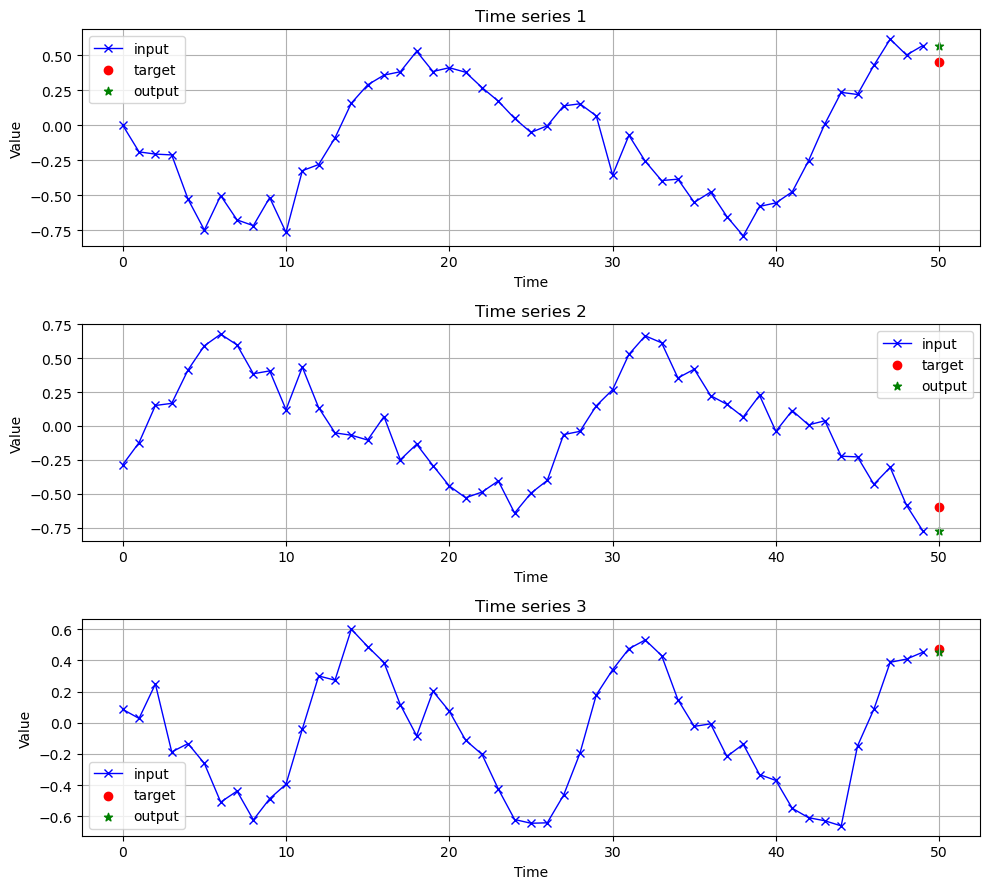

In [64]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device)
    target = torch.tensor(y_valid[i], device=device)
    output = y_pred[i]
    target = target.cpu().detach().numpy()
    axs[i].plot(input.cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="target")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="output")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [65]:
# linear model

class LinearLayer(nn.Module):
    def __init__(self, n_steps, n_hidden=50):
        super(LinearLayer, self).__init__()
        self.fc1 = nn.Linear(n_steps, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [66]:
def train_linear_model(model,num_epochs=20,batch_size=32,lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    losses = []
    
    for i in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # loss = F.mse_loss(outputs, targets.view(-1, 1))
            loss = torch.sqrt(torch.sum((outputs - targets.view(-1, 1)) ** 2)) / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        if (i+1) % 10 == 0: 
            print(f"epoch {i+1}/{num_epochs}, training loss = {epoch_loss:4e}", end="\r")

    return losses

In [69]:
ll = LinearLayer(n_steps).to(device)

losses = train_linear_model(ll, num_epochs=100, batch_size=32, lr=1e-2)

y_pred = ll(torch.tensor(X_valid).to(device))
y_pred = y_pred.cpu().detach().numpy()
print(f"\n{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

epoch 100/100, training loss = 1.938331e-02
0.4491 RMSE


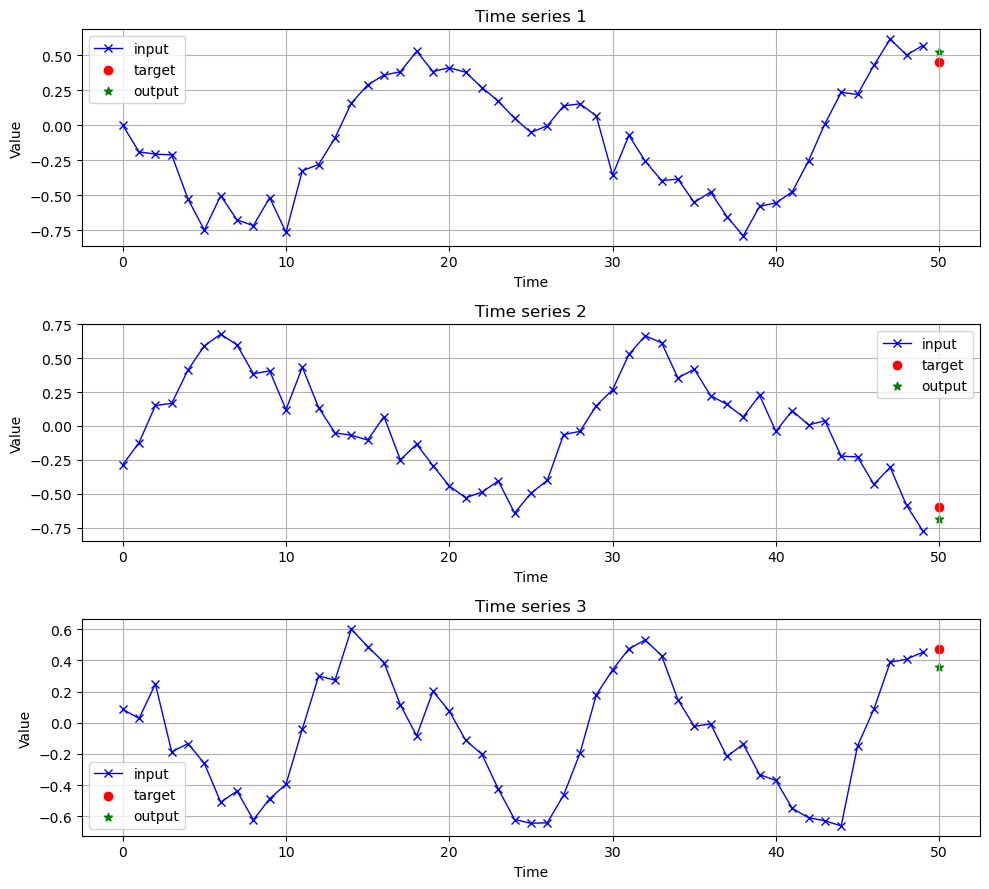

In [68]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device)
    target = torch.tensor(y_valid[i], device=device)
    output = ll(input)
    output = output.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    axs[i].plot(input.cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="target")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="output")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

Basic Torch RNN